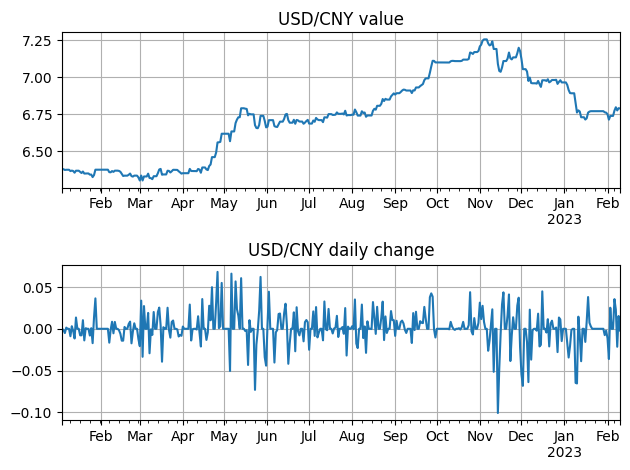

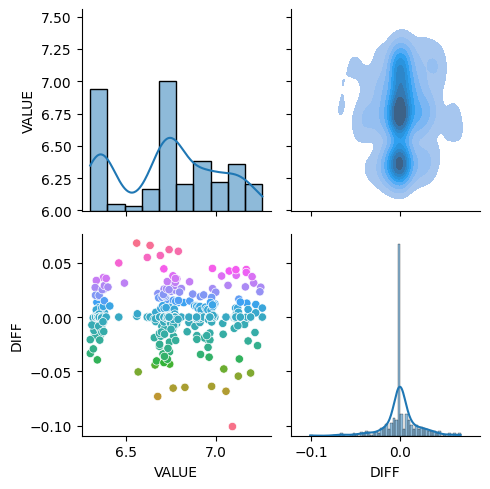

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

import seaborn as sns

config = {'user': 'mfraynt',
          'password': '18989828',
          'host': '127.0.0.1',
          'database': 'db',
          'raise_on_warnings': True,
          'use_pure': False}

engine = create_engine(f"mysql+pymysql://{config['user']}:{config['password']}@{config['host']}/{config['database']}", echo=False)

# Get data for USD/CNY 
sql = ("SELECT DATE, NOMINAL, VALUE FROM currencies "
       "WHERE SOURCE = 'CFETS' AND CURRENCY = 'USD/CNY';")
df1 = pd.read_sql(sql, con=engine)

idx = pd.date_range(min(df1.DATE), max(df1.DATE))
df1 = df1.set_index("DATE")
df1 = df1.reindex(idx)
df1 = df1.fillna(method='ffill')

df1['DIFF'] = df1.VALUE - df1.VALUE.shift(1)
df1.DIFF = df1.DIFF.fillna(0)


plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(2,1)
df1.drop("NOMINAL", axis=1).VALUE.plot(ax=axes[0], grid=True, title='USD/CNY value')
df1.drop("NOMINAL", axis=1).DIFF.plot(ax=axes[1], grid=True, title='USD/CNY daily change')

g = sns.PairGrid(df1.drop("NOMINAL", axis=1))
g.map_diag(sns.histplot, kde=True)
g.map_upper(sns.kdeplot, fill=True)
g.map_lower(sns.scatterplot, hue=df1.DIFF, palette='husl')

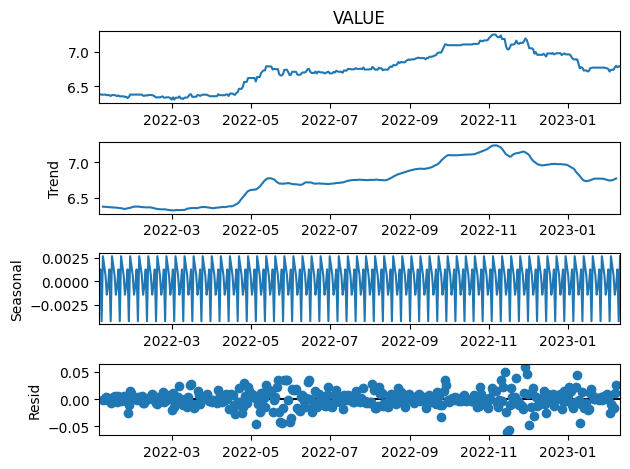

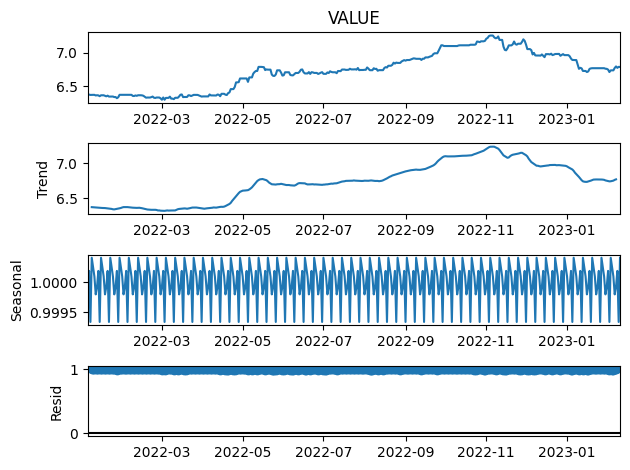

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df1.VALUE,model = 'add')
result_add.plot();
result_mul = seasonal_decompose(df1.VALUE,model = 'mul')
result_mul.plot();

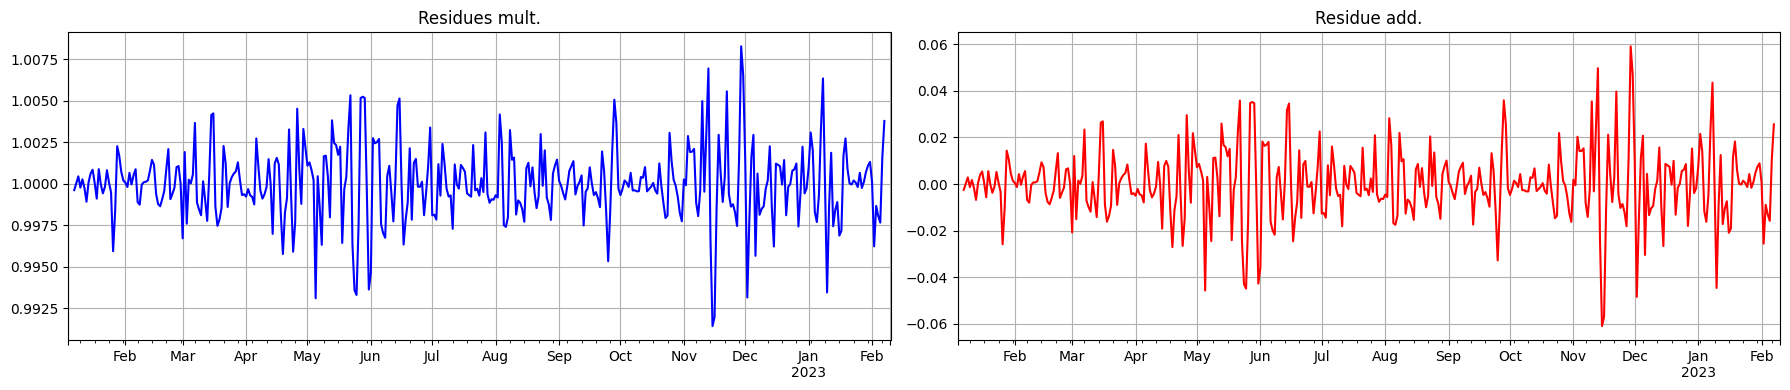

In [19]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(18,4)
resid_mul = result_mul.resid
resid_mul.plot(color='blue', ax=axes[0], title='Residues mult.', grid=True);
resid_add = result_add.resid
resid_add.plot(color='red', ax=axes[1], title='Residue add.', grid=True);

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     909.7
Date:                Fri, 10 Feb 2023   Prob (F-statistic):          3.54e-105
Time:                        17:14:30   Log-Likelihood:                 186.96
No. Observations:                 403   AIC:                            -369.9
Df Residuals:                     401   BIC:                            -361.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3348      0.015    417.638      0.000       6.305       6.365
x1             0.0020   6.53e-05     30.161      0.000       0.002       0.002
==============================================================================
Omnibus:                       10.297   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.454
Skew:                          -0.391   Prob(JB):                      0.00537
Kurtosis:                       3.102   Cond. No.                         464.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

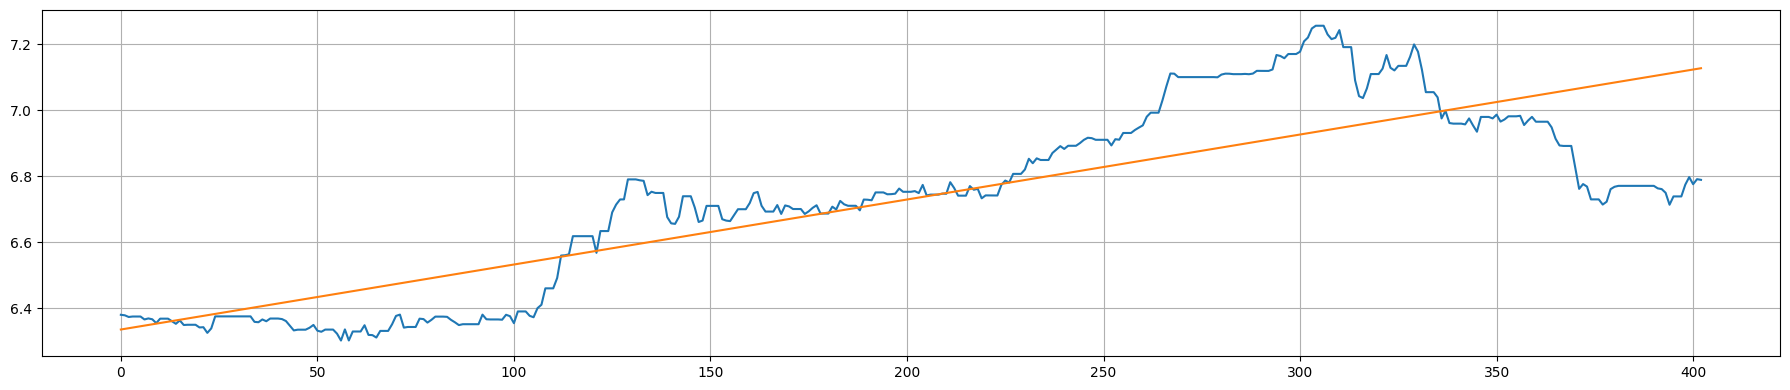

In [20]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
x=np.arange(len(df1))
y=df1.VALUE.values
polynomial_features= PolynomialFeatures(degree=1)
xp = polynomial_features.fit_transform(x.reshape(-1,1))
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape

plt.figure(figsize=(18,4))
plt.plot(x,y)
plt.grid()
plt.plot(x, ypred)

model.summary()

In [5]:

model =  sm.tsa.SARIMAX()
# train = df1[:int(len(df1)*0.8)]
# test = df1[int(len(df1)*0.8):]

TypeError: SARIMAX.__init__() missing 1 required positional argument: 'endog'